№1. Для усреднения значений и построения дендрограммы с использую jupyter notebook.

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

In [2]:
scc_list = ('outputSCC_lib.txt', 
            'outputSCC_Kc167.txt', 
            'outputSCC_lib_Kc_1.txt', 
            'outputSCC_lib_Kc_2.txt', 
            'outputSCC_lib_Kc_3.txt', 
            'outputSCC_lib_Kc_4.txt')
scc_dist = []

for i in range(len(scc_list)):
    with open(scc_list[i], 'r') as f:
        lib = f.readlines()
    scc = [float(x.strip()) for x in lib[2:-1]]
    scc = [i for x, i in enumerate(scc) if x in [x - 1 for x in [1, 3, 5, 7, 9, 12]]]
    scc_dist.append(np.mean(scc))

print(scc_dist)

[0.85045980851829, 0.8368286767714815, 0.5409096974046415, 0.5684901964584212, 0.5727378813725648, 0.5404668147418871]


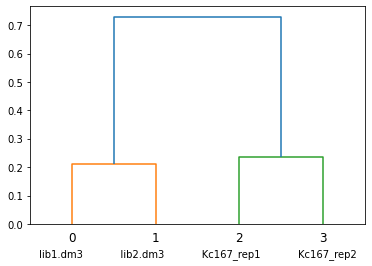

In [3]:
names = ('lib1.dm3', 'lib2.dm3', 'Kc167_rep1', 'Kc167_rep2')
dist_matrix = np.array([[1, scc_dist[0], scc_dist[4], scc_dist[2]],
                        [scc_dist[0], 1,scc_dist[3], scc_dist[5]],
                        [scc_dist[4], scc_dist[3], 1, scc_dist[1]],
                        [scc_dist[2], scc_dist[5], scc_dist[1], 1]])
dm = hierarchy.linkage(dist_matrix, 'single')
dn = hierarchy.dendrogram(dm)
plt.xlabel("            ".join(names)) # пришлось сделать так, подписи не хотели рисоваться красиво
plt.show()

Чего и следовало ожидать, реплики нервной и эмбриональной ткани класторизовались соответствуюшим образом - нервные вместе и эмбриональные тоже.

№2. Посмотрим на распределение размеров ТАДов.

При стандартных параметрах.

mean length of TADs 224575


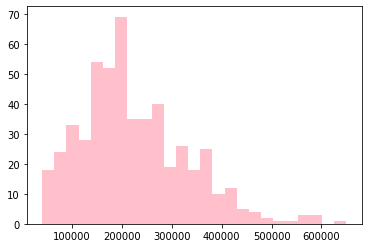

In [4]:
tads_default = pd.read_csv('tads/TADs_domains.bed', sep='\t', header=None)
tads_default_len = [x - y for x, y in zip(tads_default[2].tolist(), tads_default[1].tolist())]
print('mean length of TADs', np.mean(tads_default_len, dtype=int))
plt.hist(tads_default_len, bins=25, color='pink')
plt.show()

Далее варианты при изменении параметров minDepth (30k, 100k, 200k) и –maxDepth (50k, 100k, 250k, 500k, 1M).

In [5]:
depth = ('tads/TAD_30k_60k_domains.bed',
        'tads/TAD_30k_100k_domains.bed',
        'tads/TAD_30k_150k_domains.bed',
        'tads/TAD_30k_250k_domains.bed',
        'tads/TAD_30k_500k_domains.bed',
        'tads/TAD_30k_1M_domains.bed',
        'tads/TAD_100k_1M_domains.bed',
        'tads/TAD_200k_1M_domains.bed')

In [6]:
def tads_length(file_name):
    tads = pd.read_csv(file_name, sep='\t', header=None)
    
    tads_params = file_name.split('_')
    
    tads_len = [x - y for x, y in zip(tads[2].tolist(), tads[1].tolist())]
    
    print('-minDepth', tads_params[1], '-maxDepth', tads_params[2])
    print('mean length of TADs', np.mean(tads_len, dtype=int))
        
    plt.hist(tads_len, bins=25, color='pink')
    plt.show()

-minDepth 30k -maxDepth 60k
mean length of TADs 146553


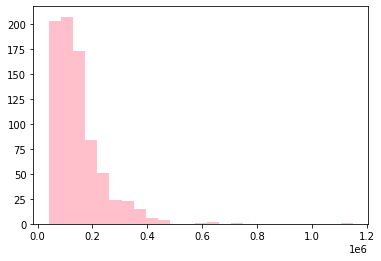

-minDepth 30k -maxDepth 100k
mean length of TADs 157921


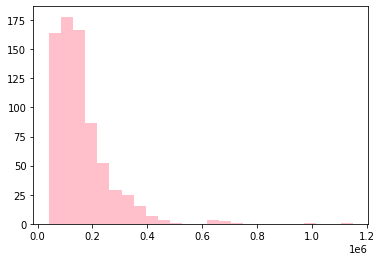

-minDepth 30k -maxDepth 150k
mean length of TADs 164194


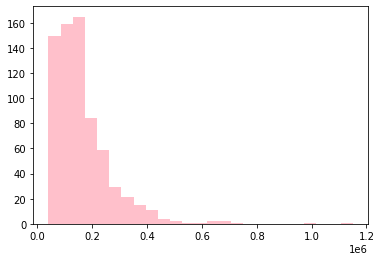

-minDepth 30k -maxDepth 250k
mean length of TADs 168478


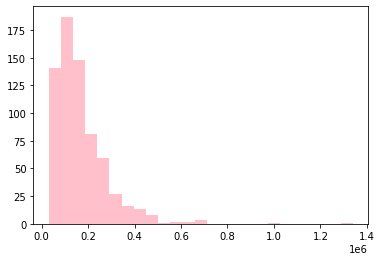

-minDepth 30k -maxDepth 500k
mean length of TADs 178586


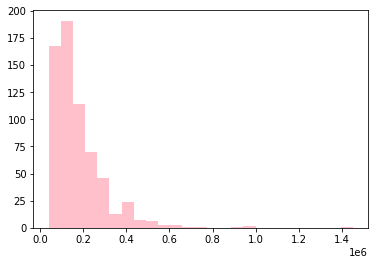

-minDepth 30k -maxDepth 1M
mean length of TADs 182032


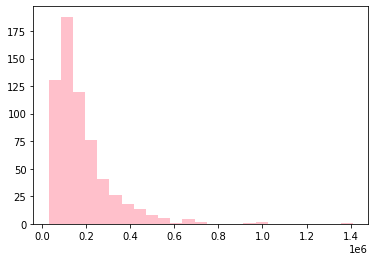

-minDepth 100k -maxDepth 1M
mean length of TADs 238020


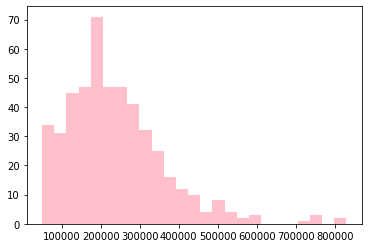

-minDepth 200k -maxDepth 1M
mean length of TADs 325071


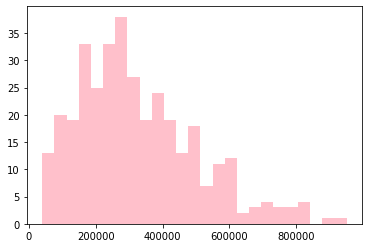

In [7]:
for i in depth:
    tads_length(i)

При изменении параметров изменяется размер ТАДов.

№4 Посчитаем количество генов, попадающих на границы ТАДов и в сами ТАДы.

In [8]:
TADs_boundaries = pd.read_csv('TADs_boundaries.bed', sep='\t', header=None)
TADs_boundaries.sort_values(by=1)
TADs_boundaries.head()

,0,1,2,3,4,5
0,chr2L,105000,115000,B00011,-0.531479,.
1,chr2L,245000,255000,B00025,-0.398021,.
2,chr2L,475000,485000,B00048,-0.615428,.
3,chr2L,545000,555000,B00055,-0.698989,.
4,chr2L,845000,855000,B00085,-0.606603,.


In [9]:
drosophila = pd.read_csv('drosophila.txt')
drosophila.sort_values(by='Gene start (bp)')
drosophila.head()

,Gene stable ID,Gene start (bp),Gene end (bp),Strand
0,FBgn0031208,7529,9484,1
1,FBgn0002121,9839,21376,-1
2,FBgn0031209,21823,25155,-1
3,FBgn0263584,21952,24237,1
4,FBgn0051973,25402,65404,-1


In [10]:
gene_start = drosophila['Gene start (bp)'].tolist()
gene_end = drosophila['Gene end (bp)'].tolist()

i = 0 # итератор генов
b = 0 # попадает на границу
x = 0 # подает внутрь ТАДа
for n in range(len(TADs_boundaries)):
    while gene_end[i] < TADs_boundaries[1][n]:
        i += 1
    if TADs_boundaries[1][n] < gene_start[i] < TADs_boundaries[2][n] or \
    TADs_boundaries[1][n] < gene_end[i] < TADs_boundaries[2][n]:
        while TADs_boundaries[1][n] < gene_start[i] < TADs_boundaries[2][n] or \
        TADs_boundaries[1][n] < gene_end[i] < TADs_boundaries[2][n]:
            b += 1
            i += 1
    elif TADs_boundaries[2][n] < gene_start[i] < TADs_boundaries[1][n+1] or \
    TADs_boundaries[2][n] < gene_end[i] < TADs_boundaries[1][n+1]:
        if n < len(TADs_boundaries):
            while TADs_boundaries[2][n] < gene_start[i] < TADs_boundaries[1][n+1] or \
            TADs_boundaries[2][n] < gene_end[i] < TADs_boundaries[1][n+1]:
                x += 1
                i += 1
    elif TADs_boundaries[2][n] < gene_start[i]:
        while n < len(TADs_boundaries):
            if TADs_boundaries[2][n] > gene_start[i]:
                break
            n += 1
            continue
        if n == len(TADs_boundaries):     
            break

print('in boundaries:', b)
print('in TADs:', x)

in boundaries: 447
in TADs: 246


На границы ТАДов попадает больше генов, чем на сами ТАДы.

Теперь сделаем тоже самое для максимально экспрессированных генов.

In [11]:
genes = pd.read_csv('BG3_genes.txt', sep='\t')
genes['BG3_FPKM'] = genes['BG3_FPKM'].str.replace(',','.').astype(float)
genes.head()

,Gene_ID,BG3_FPKM
0,FBgn0031208,0.817405
1,FBgn0002121,28.118300
2,FBgn0031209,0.000000
3,FBgn0051973,0.045719
4,FBgn0067779,9.861980


In [12]:
max_exp_genes = genes.sort_values(by='BG3_FPKM')[-401:]
max_exp_genes.head()

,Gene_ID,BG3_FPKM
6259,FBgn0035271,225.647
14916,FBgn0031066,225.924
11368,FBgn0016119,226.114
11402,FBgn0040227,226.796
3824,FBgn0000253,227.485


In [13]:
max_exp_coords = drosophila.loc[drosophila['Gene stable ID'].isin(max_exp_genes['Gene_ID'])]
max_exp_coords.head()

,Gene stable ID,Gene start (bp),Gene end (bp),Strand
17,FBgn0031228,114726,156030,1
80,FBgn0002593,419952,420864,1
101,FBgn0031263,559612,560523,1
256,FBgn0000579,1724768,1729636,-1
291,FBgn0001125,1984512,1987758,-1


In [14]:
print('found:', len(max_exp_coords))

found: 340


In [15]:
gene_start = max_exp_coords['Gene start (bp)'].tolist()
gene_end = max_exp_coords['Gene end (bp)'].tolist()

i = 0 # итератор генов
b = 0 # попадает на границу
x = 0 # подает внутрь ТАДа
for n in range(len(TADs_boundaries)):
    while gene_end[i] < TADs_boundaries[1][n]:
        i += 1
    if TADs_boundaries[1][n] < gene_start[i] < TADs_boundaries[2][n] or \
    TADs_boundaries[1][n] < gene_end[i] < TADs_boundaries[2][n]:
        while TADs_boundaries[1][n] < gene_start[i] < TADs_boundaries[2][n] or \
        TADs_boundaries[1][n] < gene_end[i] < TADs_boundaries[2][n]:
            b += 1
            i += 1
    elif TADs_boundaries[2][n] < gene_start[i] < TADs_boundaries[1][n+1] or \
    TADs_boundaries[2][n] < gene_end[i] < TADs_boundaries[1][n+1]:
        if n < len(TADs_boundaries):
            while TADs_boundaries[2][n] < gene_start[i] < TADs_boundaries[1][n+1] or \
            TADs_boundaries[2][n] < gene_end[i] < TADs_boundaries[1][n+1]:
                x += 1
                i += 1
    elif TADs_boundaries[2][n] < gene_start[i]:
        while n < len(TADs_boundaries):
            if TADs_boundaries[2][n] > gene_start[i]:
                break
            n += 1
            continue
        if n == len(TADs_boundaries):     
            break

print('in boundaries:', b)
print('in TADs:', x)

in boundaries: 19
in TADs: 56


Наблюдаем картину обратную набору всех генов: в ТАДах экспрессирущихся генов больше.